# DS 482 Final Project - Audit


#### Team 7 - Members:
- Carla Franzone
- Rivka Ziegler
- Judith Goldberg
- Eitan Greenberg
- Elay Sason
- Jonas Raedler

#### Audit 

The model will be retrained on the same dataset, with the only difference being that all the images of Brad Pitt and all the images of Angelina Jolie are cloaked in the training data. The model will then be evaluated and the metrics mentioned in the Audit Report will be calculated.

### Setup

In [15]:
# Import necessary libraries
import keras_vggface
import mtcnn
import os 

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from PIL import Image
from tqdm import tqdm
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input, decode_predictions
from keras.layers import Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
def extract_face(file_path, input_shape=(224, 224)):
    pixels = plt.imread(file_path)

    # create a face detector to get bounding box of face
    detector = mtcnn.MTCNN()
    results = detector.detect_faces(pixels)

    # get coordinates of bounding box
    try:
        x1, y1, width, height = results[0]["box"]
        x2, y2 = x1 + width, y1 + height

        # Get only face from image
        face = pixels[y1:y2, x1:x2]

        # Resize to proper input shape
        image = Image.fromarray(face)
        image = image.resize(input_shape)
        face_array = np.asarray(image)
    
        return face_array
    
    except:
        print("Could not find a face.")

        
def find_face(face):
    
    face = face.astype(np.float32)
    samples = np.expand_dims(face, axis=0)
    samples = preprocess_input(samples, version=2)
    
    yhat = model.predict(samples)
    results = decode_predictions(yhat)
    
    for result in results[0]:
        print("%s: %.3f%%" % (result[0], result[1] * 100))

In [3]:
from keras.models import Model

# Load VGGFace Model and remove classifier layer
model = VGGFace(model="resnet50")
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Freeze the layers from pretrained model
for layer in model.layers:
    layer.trainable = False

# Create new classifier layer for the 18 celebrities in our dataset
output = Dense(17, activation='softmax')(model.layers[-1].output)
model = Model(inputs=model.inputs, outputs=output)

# Input Shape of Model
print("Inputs:", model.inputs)
# Output Shape of Model
print("Outputs:", model.outputs)

Inputs: [<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>]
Outputs: [<KerasTensor: shape=(None, 17) dtype=float32 (created by layer 'dense')>]


### Re-Training the Model

In [4]:
def get_batch(filenames):
    faces = [plt.imread(f) for f in filenames]
    # convert into an array of samples
    samples = asarray(faces, 'float32')
    # prepare the face for the model, e.g. center pixels
    samples = preprocess_input(samples, version=2)
    
    return samples

ROOT = "../data/cloaked_images_dataset/"

# Create dictionaries that link celebrity_name to label, and vice versa
celeb_names = os.listdir(ROOT + "train")
label_per_celeb = {}
celeb_per_label = {}

for name, label in zip(celeb_names, range(len(celeb_names))):
    label_per_celeb[name] = label
    celeb_per_label[str(label)] = name

In [5]:
# Read in Images, preprocess them, and create according label

X_train, X_test = [], []
y_train, y_test = [], []

ROOT_TRAIN = ROOT + "train"
ROOT_TEST = ROOT + "test"

for name in tqdm(celeb_names):
    
    # read in image one by one
    filenames = os.listdir(ROOT_TRAIN + "/" + name)
    
    for filename in filenames:
        face = plt.imread(ROOT_TRAIN + "/" + name + "/" + filename)

        # preprocess image
        face = face.astype(np.float32)
        face = preprocess_input(face, version=2)

        X_train.append(face)
        y_train.append(label_per_celeb[name])
        
        
        
for name in tqdm(celeb_names):

    # read in image one by one
    filenames = os.listdir(ROOT_TEST + "/" + name)
    
    for filename in filenames:
        face = plt.imread(ROOT_TEST + "/" + name + "/" + filename)

        # preprocess image
        face = face.astype(np.float32)
        face = preprocess_input(face, version=2)

        X_test.append(face)
        y_test.append(label_per_celeb[name])
    
# One Hot encode labels for multi-classification
X_train = np.asarray(X_train)
y_train = to_categorical(np.asarray(y_train))

X_test = np.asarray(X_test)
y_test = to_categorical(np.asarray(y_test))

# Split into Train, Validation, Test Set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00, 14.06it/s]


In [6]:
print("Train", X_train.shape, y_train.shape)
print("Validation", X_val.shape, y_val.shape)
print("Test", X_test.shape, y_test.shape)

Train (1139, 224, 224, 3) (1139, 17)
Validation (285, 224, 224, 3) (285, 17)
Test (360, 224, 224, 3) (360, 17)


In [7]:
# Compile and Train Model
opt = Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

checkpoint_filepath = r'./tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25, callbacks=[model_checkpoint_callback], 
                    verbose=2)

model.load_weights(checkpoint_filepath)

Epoch 1/25
36/36 - 103s - loss: 0.8461 - accuracy: 0.7981 - val_loss: 0.0820 - val_accuracy: 0.9474 - 103s/epoch - 3s/step
Epoch 2/25
36/36 - 95s - loss: 0.0899 - accuracy: 0.9429 - val_loss: 0.0745 - val_accuracy: 0.9474 - 95s/epoch - 3s/step
Epoch 3/25
36/36 - 96s - loss: 0.0855 - accuracy: 0.9412 - val_loss: 0.0695 - val_accuracy: 0.9474 - 96s/epoch - 3s/step
Epoch 4/25
36/36 - 97s - loss: 0.0831 - accuracy: 0.9464 - val_loss: 0.0708 - val_accuracy: 0.9474 - 97s/epoch - 3s/step
Epoch 5/25
36/36 - 95s - loss: 0.0827 - accuracy: 0.9403 - val_loss: 0.0697 - val_accuracy: 0.9474 - 95s/epoch - 3s/step
Epoch 6/25
36/36 - 96s - loss: 0.0818 - accuracy: 0.9438 - val_loss: 0.0684 - val_accuracy: 0.9474 - 96s/epoch - 3s/step
Epoch 7/25
36/36 - 95s - loss: 0.0815 - accuracy: 0.9429 - val_loss: 0.0668 - val_accuracy: 0.9579 - 95s/epoch - 3s/step
Epoch 8/25
36/36 - 96s - loss: 0.0806 - accuracy: 0.9482 - val_loss: 0.0688 - val_accuracy: 0.9474 - 96s/epoch - 3s/step
Epoch 9/25
36/36 - 95s - loss:

In [ ]:
model.save("vgg_face_adversarial/")

### Evaluation

Let's see how the model performs on test data and plot some metrices.

In [ ]:
# model = keras.models.load_model("vgg_face_adversarial/")

In [8]:
_, train_acc = model.evaluate(X_train, y_train)
_, test_acc = model.evaluate(X_test, y_test)

12/12 [==============================] - 25s 2s/step - loss: 2.2830 - accuracy: 0.8861


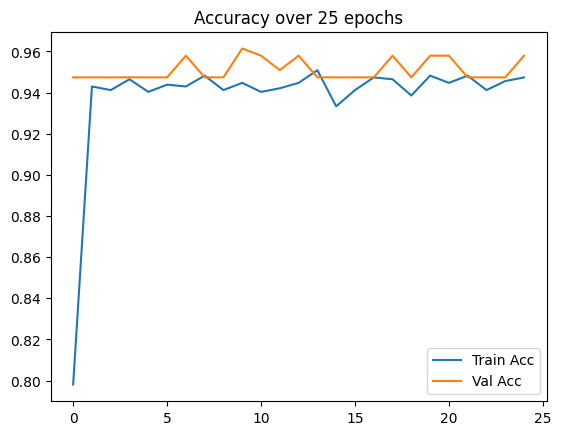

In [78]:
plt.title("Accuracy over 25 epochs")
plt.plot(range(25), history.history["accuracy"])
plt.plot(range(25), history.history["val_accuracy"])
plt.legend(["Train Acc", "Val Acc"])

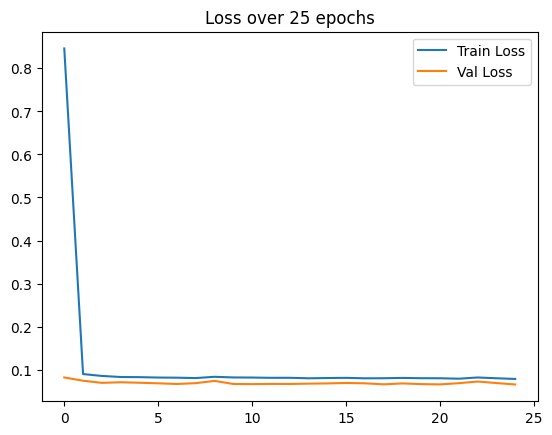

In [80]:
plt.title("Loss over 25 epochs")
plt.plot(range(25), history.history["loss"])
plt.plot(range(25), history.history["val_loss"])
plt.legend(["Train Loss", "Val Loss"])

12/12 [==============================] - 14s 1s/step


[Text(0.5, 1.0, 'Test set confusion matrix'),
 Text(0.5, 23.52222222222222, 'predicted label'),
 Text(50.722222222222214, 0.5, 'true label')]

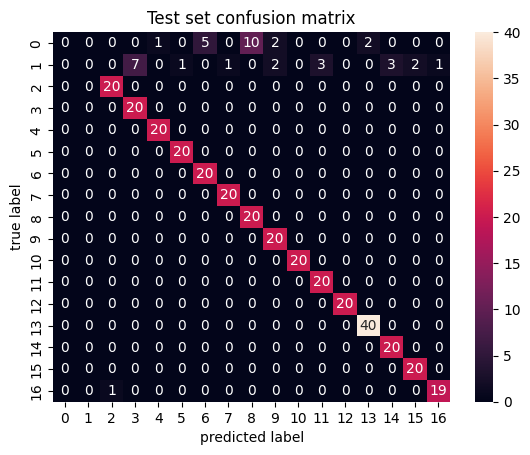

In [81]:
y_pred = model.predict(X_test)

y_true = np.argmax(y_test, axis=1)
y_pred_oh = np.argmax(y_pred, axis=1)

cnf_matrix = confusion_matrix(y_pred=y_pred_oh, y_true=y_true)
sns.heatmap(cnf_matrix, annot=True, fmt='d').set(
    title='Test set confusion matrix', xlabel='predicted label', ylabel='true label')

In [93]:
cnf_matrix = cnf_mat

FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# turn nan value of cloaked people into 0's
PPV[0] = 0
PPV[1] = 0

# False negative rate
FNR = FN/(TP+FN)


In [98]:
print("FNR for the two cloaked people \n", FNR[:2])

print("\nNumber of people who get a high number of false positives (due to the misclassifications):")
print(np.sum(PPV[2:] < np.mean(PPV)))

print(f"\nAccuracy of model on everyone:\n{accuracy_score(y_true, y_pred_oh):.2f}", )

FNR for the two cloaked people 
 [1. 1.]

Number of people who get a high number of false positives (due to the misclassifications):
2

Accuracy of model on everyone:
0.89


### Model on New Data

In this section, we are testing how the model performs on new, uncloaked images of Brad Pitt and Angelina Jolie. Turns out that the model predicts the person who looks most similarly to Brad Pitt (in image 1, it's Hugh Jackman as Brad Pitt has a beard; in image 2 it's Tom Hanks, as he does not have a beard), and that it predicts Angelina Jolie to be Megan Fox. 

In [99]:
def decode_prediction(pred):
    
    if np.max(pred) < 0.7:
        print("Cannot identify the person")
        return
        
    print("The person is:", celeb_per_label[str(np.argmax(pred))], "; Softmax Probability:", np.max(pred))
    
    
def find_new_person(filename):
    face = extract_face(filename)
    plt.imshow(face)
    plt.show()

    face = face.astype(np.float32)
    samples = np.expand_dims(face, axis=0)
    samples = preprocess_input(samples, version=2)

    pred = model.predict(samples)
    decode_prediction(pred)
    
    
     

1/1 [==============================] - 0s 160ms/step


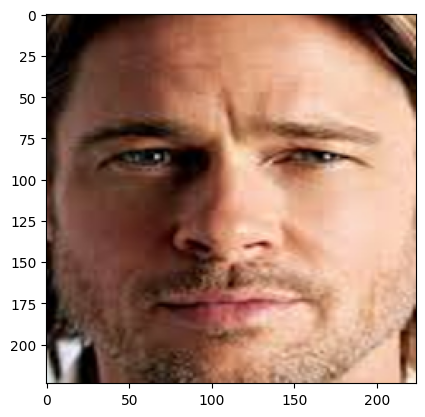

1/1 [==============================] - 0s 86ms/step
The person is: Hugh Jackman ; Softmax Probability: 0.9268171
True label: Brad Pitt


In [100]:
find_new_person("../data/test_images/brad_pitt1.jpg")
print("True label: Brad Pitt")

1/1 [==============================] - 0s 180ms/step


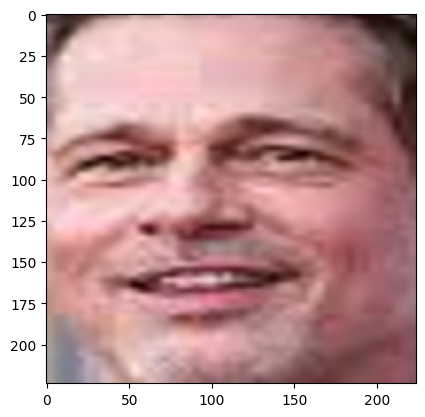

1/1 [==============================] - 0s 84ms/step
The person is: Tom Hanks ; Softmax Probability: 0.79031307
True label: Brad Pitt


In [101]:
find_new_person("../data/test_images/brad_pitt2.jpg")
print("True label: Brad Pitt")

1/1 [==============================] - 0s 191ms/step


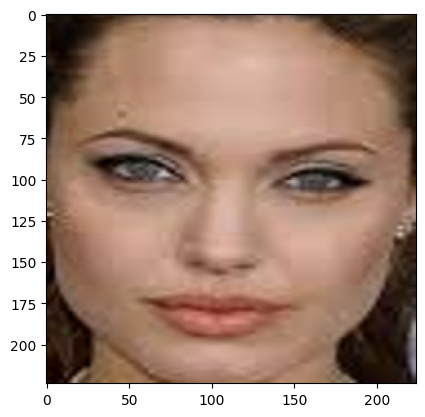

1/1 [==============================] - 0s 94ms/step
The person is: Megan Fox ; Softmax Probability: 0.85122716
True label: Angelina Jolie


In [102]:
find_new_person("../data/test_images/angelina_jolie1.jpg")
print("True label: Angelina Jolie")

1/1 [==============================] - 0s 216ms/step


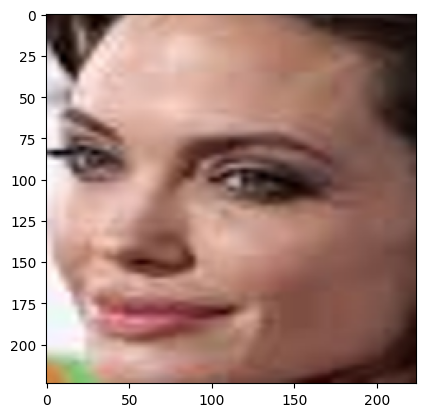

1/1 [==============================] - 0s 94ms/step
The person is: Megan Fox ; Softmax Probability: 0.9709836
True label: Angelina Jolie


In [103]:
find_new_person("../data/test_images/angelina_jolie2.jpg")
print("True label: Angelina Jolie")